# [과제2] 조별과제 텐서 => 파이토치 구현

In [1]:
import os
import time
import copy
import json
import math
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob
from tqdm import tqdm
from PIL import Image

plt.rcParams['font.family'] = 'NanumGothic'
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
root = Path("D:/").resolve()
base = root / "Apple_data"
cate_data = base / "dataset_cate"
train_data = cate_data / 'train'
val_data = cate_data / 'val'

In [3]:
classes_list = ['아리수', '홍로', '후지']
for clss in classes_list:
    path = os.path.join(cate_data, clss)
    fnames = os.listdir(path)

    train_size = math.floor(len(fnames) * 0.8)
    validation_size = math.floor(len(fnames) * 0.2)

    train_fnames = fnames[:train_size]
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_data, clss), fname)
        shutil.copyfile(src, dst)

    validation_fnames = fnames[train_size:(train_size + validation_size)]
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(val_data, clss), fname)
        shutil.copyfile(src, dst)

In [4]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
BATCH_SIZE = 32
EPOCH = 30
IMG_SIZE = 220

## 데이터 증강

In [5]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
image_datasets = {
    x: ImageFolder(root=os.path.join(cate_data, x),
                   transform=data_transforms[x])
    for x in ['train', 'val']
}
dataloaders = {
    x: DataLoader(image_datasets[x],
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


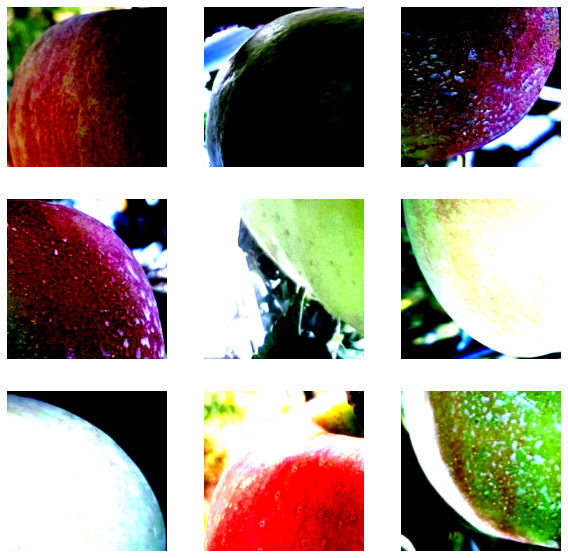

In [7]:
plt.figure(figsize=(10, 10))
for index, (data, target) in enumerate(dataloaders['train']):
    if index == 9:
        break
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(data[0].permute(1, 2, 0))
    plt.axis('off')

In [12]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier = nn.Sequential(
    nn.Linear(vgg16.classifier[0].in_features, out_features=256, bias=True),
    nn.ReLU(True),
    nn.Linear(in_features=256, out_features=3, bias=True),
)
vgg16 = vgg16.to(DEVICE)

In [13]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
for name, param in vgg16.named_parameters():
    print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.2.weight
classifier.2.bias


In [20]:
update_param_names = [
    'classifier.0.weight',
    'classifier.0.bias',
    'classifier.2.weight',
    'classifier.2.bias',
]
params_to_update = []
for name, param in vgg16.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.0.weight
classifier.0.bias
classifier.2.weight
classifier.2.bias


In [21]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(params=params_to_update, lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # 현재 진행 중인 epoch 출력
        print('----------epoch {}----------'.format(epoch + 1))
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # 모든 데이터의 Loss를 합산해서 저장할 변수인 running_loss를 정의
            running_loss = 0.0
            # 올바르게 예측한 경위의 수를 세는 변수인 running_corrects를 정의
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                # 학습 단계에서만 모델의 Gradient를 업데이트
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                l_r = [x['lr'] for x in optimizer.param_groups]
                print('learning rate: ', l_r)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                    time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 정확도가 가장 높은 모델을 불러온 후 반환
    model.load_state_dict(best_model_wts)
    return model

In [25]:
# 앞서 정의한 train_resnet() 함수를 이용하여 Fine-Tuning
model_vgg16 = train(vgg16,
                    criterion,
                    optimizer,
                    exp_lr_scheduler,
                    num_epochs=EPOCH)

----------epoch 1----------
learning rate:  [0.001]
train Loss: 0.5945 Acc: 0.7651
val Loss: 1.0511 Acc: 0.5472
Completed in 0m 20s
----------epoch 2----------
learning rate:  [0.001]
train Loss: 0.5033 Acc: 0.7968
val Loss: 1.2312 Acc: 0.5866
Completed in 0m 20s
----------epoch 3----------
learning rate:  [0.001]
train Loss: 0.4442 Acc: 0.8281
val Loss: 1.0221 Acc: 0.5849
Completed in 0m 20s
----------epoch 4----------
learning rate:  [0.001]
train Loss: 0.4030 Acc: 0.8448
val Loss: 1.0311 Acc: 0.5866
Completed in 0m 20s
----------epoch 5----------
learning rate:  [0.001]
train Loss: 0.3476 Acc: 0.8714
val Loss: 1.1376 Acc: 0.6055
Completed in 0m 20s
----------epoch 6----------
learning rate:  [0.0001]
train Loss: 0.2919 Acc: 0.8937
val Loss: 1.0507 Acc: 0.6123
Completed in 0m 19s
----------epoch 7----------
learning rate:  [0.0001]
train Loss: 0.2150 Acc: 0.9250
val Loss: 1.0315 Acc: 0.6312
Completed in 0m 20s
----------epoch 8----------
learning rate:  [0.0001]
train Loss: 0.1954 Ac

In [ ]:
from numba import cuda

device = cuda.get_current_device()
device.reset()